# TabNet: Hyperparameter Optimization

*   Jacob Yousif

## Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%%capture
!pip install optuna==3.6.1

In [5]:
%%capture

import pandas as pd
import numpy as np
import joblib
import time

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

## Process

In [7]:
npz_file_path = 'datasets/hypertuning_train_set/LearningSet.npz'
data = np.load(npz_file_path, allow_pickle=True)

In [8]:
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
features = data['feature_names']

In [9]:
features

array(['Duration', 'ProtocolCode', 'ServiceCode', 'StateCode',
       'SourcePackets', 'DestinationPackets', 'SourceBytes',
       'DestinationBytes', 'FlowRate', 'SourceTTL', 'DestinationTTL',
       'SourceLoad', 'DestinationLoad', 'SourceLoss', 'DestinationLoss',
       'SourceInterPacketTime', 'DestinationInterPacketTime',
       'SourceJitter', 'DestinationJitter', 'SourceTCPWindow',
       'SourceTCPBaseSequence', 'DestinationTCPBaseSequence',
       'DestinationTCPWindow', 'TCPRTT', 'TCPSYNACK', 'TCPACKDelta',
       'SourcePacketMeanSize', 'DestinationPacketMeanSize',
       'TransactionDepth', 'ResponseBodyLength', 'RecordServiceSource',
       'RecordStateTTL', 'RecordDestinationLTM', 'RecordSourceDPortLTM',
       'RecordDestinationSPortLTM', 'RecordDestinationSourceLTM',
       'IsFTPLogin', 'RecordFTPCommands', 'RecordFlowHTTPMethods',
       'RecordSourceLTM', 'RecordServiceDestination', 'IsSmallIPSPorts'],
      dtype='<U26')

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (113921, 42)
y_train shape: (113921,)
X_val shape: (24412, 42)
y_val shape: (24412,)


In [11]:
results = []
total = 0
best_accuracy = 0.0

In [12]:
def objective(trial):
    global total
    global results
    global best_accuracy
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64),
        'n_a': trial.suggest_int('n_a', 8, 16),
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0, step=0.1),
        'n_shared': trial.suggest_int('n_shared', 1, 5),
        'momentum': trial.suggest_float('momentum', 0.01, 0.4, step=0.01),
        'optimizer_function': trial.suggest_categorical('optimizer_function', [torch.optim.Adam, torch.optim.SGD]),
        'batch_size': trial.suggest_categorical('batch_size', [128, 256, 512, 1024])
    }

    model = TabNetClassifier(
        n_d=params['n_d'],
        n_a=params['n_a'],
        n_steps=params['n_steps'],
        gamma=params['gamma'],
        momentum=params['momentum'],
        n_shared=params['n_shared'],
        optimizer_fn=params['optimizer_function'],
        verbose=0
    )

    start_time = time.time()
    model.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['accuracy'],
        max_epochs=200,
        patience=5,
        batch_size=params['batch_size'],
        virtual_batch_size=params["batch_size"] // 8
    )
    duration = time.time() - start_time

    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    total += duration

    if accuracy > best_accuracy:
        best_accuracy = accuracy

    results.append({
        'Trial': trial.number,
        'Accuracy': accuracy,
        'Duration': duration,
        'Params': params,
        'BestAccuracy': best_accuracy
    })

    return accuracy

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_accuracy = 0.69978

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_accuracy = 0.06337

Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_0_accuracy = 0.71047

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_accuracy = 0.1156

Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_0_accuracy = 0.77228

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_accuracy = 0.01569

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_accuracy = 0.72804

Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_0_accuracy = 0.78384

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_accuracy = 0.05182

Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_0_accuracy = 0.03199

Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_0_accuracy = 0.7866

In [14]:
seconds = int(total)
print('Total duration of the hypertuning process in seconds:', seconds, 'seconds.')

Total duration of the hypertuning process in seconds: 36621 seconds.


In [15]:
minutes = int(total / 60)
print('Total duration in minutes:', minutes, 'minutes.')

Total duration in minutes: 610 minutes.


In [16]:
hours = round(total / 3600, 1)
print('Total duration in hours:', hours, 'hours.')

Total duration in hours: 10.2 hours.


In [17]:
progress = pd.DataFrame(results)

In [18]:
progress

,Trial,Accuracy,Duration,Params,BestAccuracy
0,0,0.699779,1164.941859,"{'n_d': 57, 'n_a': 8, 'n_steps': 8, 'gamma': 1...",0.699779
1,1,0.063370,656.640581,"{'n_d': 56, 'n_a': 12, 'n_steps': 6, 'gamma': ...",0.699779
2,2,0.710470,970.407148,"{'n_d': 38, 'n_a': 15, 'n_steps': 9, 'gamma': ...",0.710470
3,3,0.115599,624.492740,"{'n_d': 60, 'n_a': 13, 'n_steps': 10, 'gamma':...",0.710470
4,4,0.772284,491.625834,"{'n_d': 14, 'n_a': 8, 'n_steps': 10, 'gamma': ...",0.772284
...,...,...,...,...,...
95,95,0.779166,436.379891,"{'n_d': 59, 'n_a': 11, 'n_steps': 4, 'gamma': ...",0.798337
96,96,0.733410,224.432615,"{'n_d': 54, 'n_a': 12, 'n_steps': 3, 'gamma': ...",0.798337
97,97,0.742340,101.412442,"{'n_d': 49, 'n_a': 11, 'n_steps': 3, 'gamma': ...",0.798337
98,98,0.729559,497.075412,"{'n_d': 39, 'n_a': 11, 'n_steps': 4, 'gamma': ...",0.798337


In [19]:
csv_file_path = 'results/TabNetHypertuningProgress.csv'
progress.to_csv(csv_file_path, index=False)

In [20]:
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'n_d': 51, 'n_a': 11, 'n_steps': 3, 'gamma': 2.0, 'n_shared': 5, 'momentum': 0.33, 'optimizer_function': <class 'torch.optim.adam.Adam'>, 'batch_size': 512}


In [21]:
clf = TabNetClassifier(
        n_d=best_params['n_d'],
        n_a=best_params['n_a'],
        n_steps=best_params['n_steps'],
        gamma=best_params['gamma'],
        momentum=best_params['momentum'],
        n_shared=best_params['n_shared'],
        optimizer_fn=best_params.get('optimizer_function', torch.optim.Adam),
        verbose=0
)

In [22]:
clf.fit(
        X_train=X_train,
        y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['accuracy'],
        max_epochs=200,
        patience=5,
        batch_size=best_params['batch_size'],
        virtual_batch_size=best_params["batch_size"] // 8
)


Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_0_accuracy = 0.79834


In [23]:
joblib.dump(clf,'models/TabNetModel.joblib')

['models/TabNetModel.joblib']

In [24]:
feature_importances = clf.feature_importances_

In [25]:
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

In [26]:
top_n = 10
top_features = feature_importance_df.head(top_n)

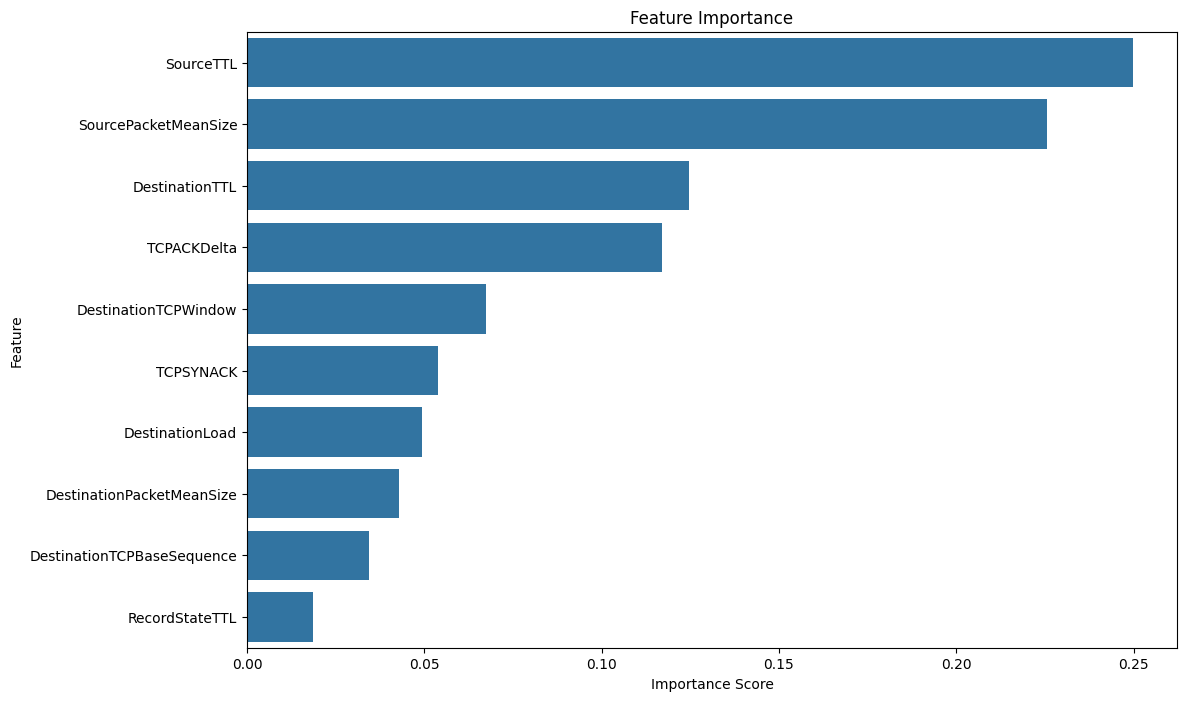

In [27]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title(f'Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.savefig('figures/features/TabNetFeatureImportance.pdf', bbox_inches='tight')
plt.show()

In [28]:
feature_importance_df.to_csv('results/TabNetFeatureImportance.csv', index=False)

In [29]:
feature_importance_df

,Feature,Importance
0,SourceTTL,2.497511e-01
1,SourcePacketMeanSize,2.256176e-01
2,DestinationTTL,1.244913e-01
3,TCPACKDelta,1.169006e-01
4,DestinationTCPWindow,6.751819e-02
5,TCPSYNACK,5.386698e-02
6,DestinationLoad,4.926946e-02
7,DestinationPacketMeanSize,4.281968e-02
8,DestinationTCPBaseSequence,3.446134e-02
9,RecordStateTTL,1.857791e-02


In [30]:
feature_importance_df.columns

Index(['Feature', 'Importance'], dtype='object')